# Perform a classification task using Zhou et al. band gap data

In [1]:
# read in data with pandas
import pandas as pd
# use numpy for vector and matrix operations
import numpy as np

# composition is a custom made python file that generates composition-based feature vectors (CBFV)
import composition
# utils is a custom made python file that has some useful functions
import utils

# make nice figures
import matplotlib.pyplot as plt
# machine learnign algorithms
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
# preprocessing for the features
from sklearn.preprocessing import StandardScaler, Normalizer
# feature reduction
from sklearn.decomposition import PCA
# import model selection tools
from sklearn.model_selection import cross_validate, cross_val_score,\
                                    cross_val_predict, learning_curve, \
                                    GridSearchCV, KFold, train_test_split
# grab metrics to evaluate our models
from sklearn.metrics import confusion_matrix, classification_report,\
                            r2_score, mean_squared_error, auc, roc_curve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# read in band gap data from Zhou et al. publication:
# J. Phys. Chem. Lett., 2018, 9 (7), pp 1668–1673
#DOI: 10.1021/acs.jpclett.8b00124
#Publication Date (Web): March 13, 2018
df_band_gap = pd.read_excel('jz8b00124_si_002.xlsx')

# excel sheet is edited to fix formula "GaAs0.1P0.9G1128" to "GaAs0.1P0.9"
df_band_gap.replace("GaAs0.1P0.9G1128", "GaAs0.1P0.9", inplace=True)

# set the columns names to 'formula' and 'target'
df_band_gap.columns = ['formula', 'target']

# fix the formula with bad formatting "AxBy, 102"
df_band_gap['formula'] = [formula.split(',')[0] for formula in df_band_gap['formula']]


In [3]:
## take the average of duplicate composition entries
df_band_gap = df_band_gap.groupby('formula').mean().reset_index()

### Because we are doing a regression, we want to change the target.
We are interesting in two classes "metal" or "non-metal". To distinguish these, we will assign a numerical label for metal (0) and non-metal (1) representing whether there is a band gap value

In [4]:
## we now need to change the target we are tying to learn.
df_band_gap['target'] = [0 if bandgap == 0 else 1 for bandgap in df_band_gap['target']]

In [5]:
# now that we have a better representation of the data, lets generate features
X, y, formula = composition.generate_features(df_band_gap)

The element: Eu from formula Ag0.5Eu1.75GeS4 is not currently supported in our database
The element: Eu from formula Ba3EuP3O12 is not currently supported in our database
The element: Eu from formula Eu1.83Ta15O32 is not currently supported in our database
The element: Eu from formula Eu2BaMn2O7 is not currently supported in our database
The element: Eu from formula Eu2C(NO)2 is not currently supported in our database
The element: Eu from formula Eu2CaO3 is not currently supported in our database
The element: Eu from formula Eu2CuO4 is not currently supported in our database
The element: Eu from formula Eu2Ga2GeS7 is not currently supported in our database
The element: Eu from formula Eu2Ga9Rh3 is not currently supported in our database
The element: Eu from formula Eu2Ge(BO4)2 is not currently supported in our database
The element: Eu from formula Eu2O3 is not currently supported in our database
The element: Eu from formula Eu2PBr is not currently supported in our database
The element:

The element: Eu from formula KEuAsS4 is not currently supported in our database
The element: Eu from formula Na0.75Eu1.625GeSe4 is not currently supported in our database
The element: Eu from formula Na2EuGeSe4 is not currently supported in our database
The element: Eu from formula Na8Eu2Ge4S12 is not currently supported in our database
The element: Pm from formula Pm2CuGe is not currently supported in our database
The element: Pm from formula Pm2IrRh is not currently supported in our database
The element: Pm from formula Pm2LiAl is not currently supported in our database
The element: Pm from formula Pm2LiGa is not currently supported in our database
The element: Pm from formula Pm2LiIr is not currently supported in our database
The element: Pm from formula Pm2LiSi is not currently supported in our database
The element: Pm from formula Pm2NiRh is not currently supported in our database
The element: Pm from formula Pm2PtAu is not currently supported in our database
The element: Pm from 

([<matplotlib.axis.XTick at 0x1ddd81ab4a8>,
 <a list of 2 Text xticklabel objects>)

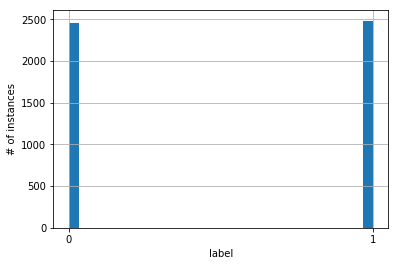

In [6]:
df_band_gap['target'].hist(bins=30)
plt.xlabel('label')
plt.ylabel('# of instances')
plt.xticks((0, 1))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# we now want to process our data. We are going to use the SVR algorithm.
# This algorithm is based on gradient descent and needs similar feature scales.

# scale each column of data to have a mean of 0 and a variance of 1
scaler = StandardScaler()
# normalizes each row in the data
normalizer = Normalizer()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(normalizer.fit_transform(X_train_scaled),
                              columns=X_train.columns.values)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(normalizer.transform(X_test_scaled),
                              columns=X_test.columns.values)

In [14]:
lr = LogisticRegression(penalty='l2', C=1e5, class_weight={0:1, 1:1} ,max_iter=100, tol=1e-2)

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train_scaled, y_train, cv=cv)

In [16]:
y_prob_both_train = cross_val_predict(lr, X_train_scaled, y_train, cv=cv, method='predict_proba')

In [17]:
y_probability_train = [probability[1] for probability in y_prob_both_train]

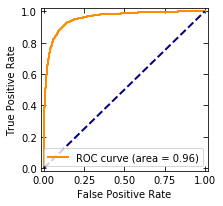

precision: 88.88, recall: 90.10
f-score: 89.49


In [18]:
utils.get_performance_metrics(y_train, y_pred_train, y_probability_train)